# Object Detection Using YOLO v5

We will use the https://github.com/ultralytics/yolov5 repository for this part of the assignment

# Step 1: Clone github repository

#### **Connect to Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pwd

'/content'

#### **Custom Dataset Setup (We will use the aerial maritime objects dataset provided for the student id 14081525)**

In [2]:
# Change path to you google drive location of the dataset as needed
!unzip '/content/gdrive/MyDrive/yolov5_last/Copia_de_dataset_42028assg2_14081525_.zip'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: Object_Detection/yolo/train/labels/100559.txt  
  inflating: Object_Detection/yolo/train/labels/101009.txt  
  inflating: Object_Detection/yolo/train/labels/101126.txt  
  inflating: Object_Detection/yolo/train/labels/101124.txt  
  inflating: Object_Detection/yolo/train/labels/101530.txt  
  inflating: Object_Detection/yolo/train/labels/101592.txt  
  inflating: Object_Detection/yolo/train/labels/100695.txt  
  inflating: Object_Detection/yolo/train/labels/100068.txt  
  inflating: Object_Detection/yolo/train/labels/102007.txt  
  inflating: Object_Detection/yolo/train/labels/101916.txt  
  inflating: Object_Detection/yolo/train/labels/100010.txt  
  inflating: Object_Detection/yolo/train/labels/100838.txt  
  inflating: Object_Detection/yolo/train/labels/100693.txt  
  inflating: Object_Detection/yolo/train/labels/100595.txt  
  inflating: Object_Detection/yolo/train/labels/100368.txt  
  inflating: Objec

#### **Clone the Github Repo (Default location /content/)**

In [3]:
# By Default Cloned under /content/
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15697, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15697 (delta 6), reused 14 (delta 4), pack-reused 15672
Receiving objects: 100% (15697/15697), 14.48 MiB | 29.65 MiB/s, done.
Resolving deltas: 100% (10747/10747), done.


#### **Install the required libraries**

In [10]:
pwd

'/content'

In [11]:
cd yolov5

/content/yolov5


In [12]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.5/586.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 21.6 MB/s eta 0:00:00


In [13]:
from yolov5 import utils

In [14]:
display = utils.notebook_init()  # checks Pytorch and GPU used


YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


# Step 2: Setup Training Configuration

When using yolo, we don't need to add background as a class, so the number of classes is 5.

In [15]:
#@title Setup Training YAML File
number_of_classes = 5 #@param {type:"integer"}
with open('new_train_yaml', 'w+') as file:
    file.write(
        f"""
        # parameters
        nc: {number_of_classes}  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

# Step 3: Setup Dataset paths

In [16]:
#@title Setup Dataset Configuration (Data.yaml)
train_data_dir = "/content/Object_Detection/yolo/train" #@param {type:"string"}
val_data_dir = "/content/Object_Detection/yolo/valid" #@param {type:"string"}
class_names = ['car', 'dock', 'boat', 'jetski', 'lift'] #@param {type:"raw"}
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train_data_dir}
        val: {val_data_dir}

        nc: {number_of_classes}
        names: {class_names}
        """
    )

# Step 4: Start Training

In [17]:
!python /content/yolov5/train.py --img 416 --batch 16 --epochs 150 --data /content/yolov5/new_data_yaml --cfg /content/yolov5/new_train_yaml

train: weights=yolov5s.pt, cfg=/content/yolov5/new_train_yaml, data=/content/yolov5/new_data_yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, 

# Step 5: Test the trained model on sample images

In [18]:
!ls /content/yolov5/runs/train/exp

confusion_matrix.png				    results.png
events.out.tfevents.1684740609.dd4b8693f5a7.1647.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


In [22]:
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/valid/images/100009.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/valid/images/100035.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/valid/images/100060.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/100119.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/100292.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101340.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/100770.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101809.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101634.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101613.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101516.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101339.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/Object_Detection/yolo/test/images/101133.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/Object_Detection/yolo/valid/images/100009.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
image 1/1 /content/Object_Detection/yolo/valid/images/100009.jpg: 320x416 1 car, 1 lift, 43.8ms
Speed: 0.4ms pre-process, 43.8ms inference, 94.6ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
detect: weights=['/content/yolov5/runs/t

# Step 6: Display result images

In [23]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline

The paths below may have to be changed, depending on the folder where the requested image is

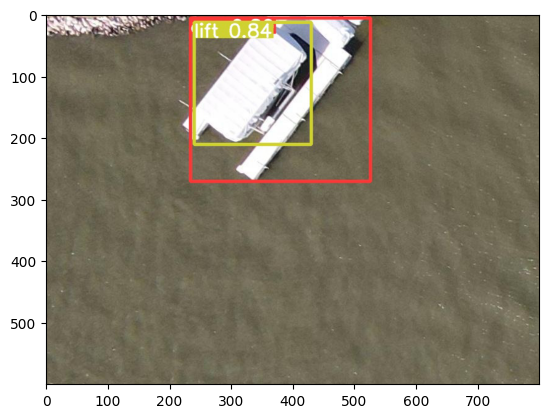

In [24]:
image = Image.open('/content/yolov5/runs/detect/exp/100009.jpg')
plt.imshow(image)

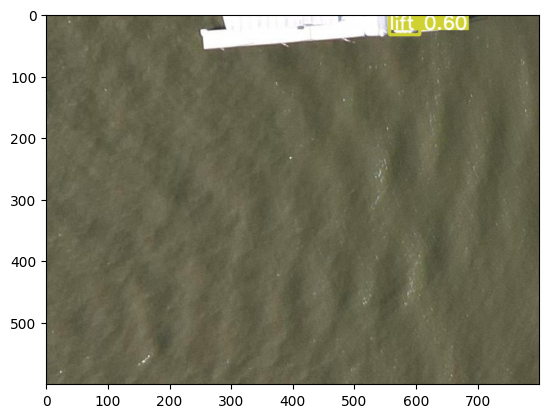

In [25]:
image = Image.open('/content/yolov5/runs/detect/exp2/100035.jpg')
plt.imshow(image)

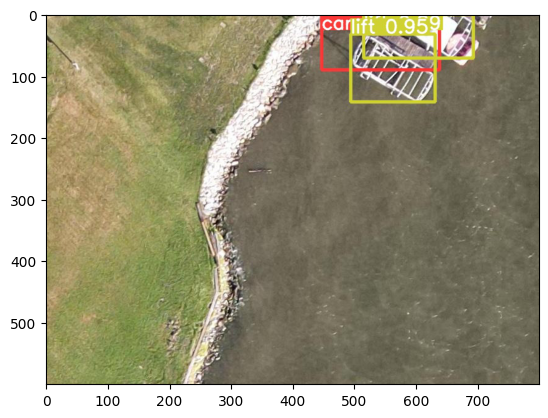

In [26]:
image = Image.open('/content/yolov5/runs/detect/exp3/100060.jpg')
plt.imshow(image)

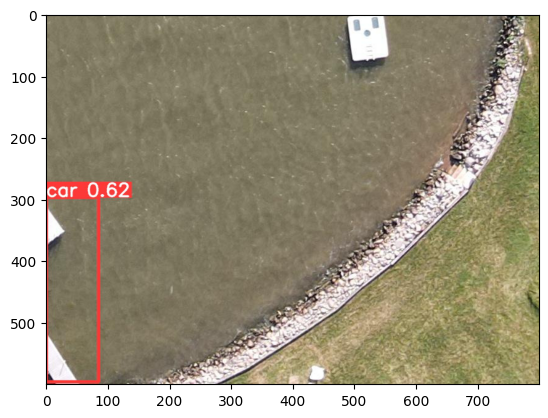

In [27]:
image = Image.open('/content/yolov5/runs/detect/exp4/100119.jpg')
plt.imshow(image)

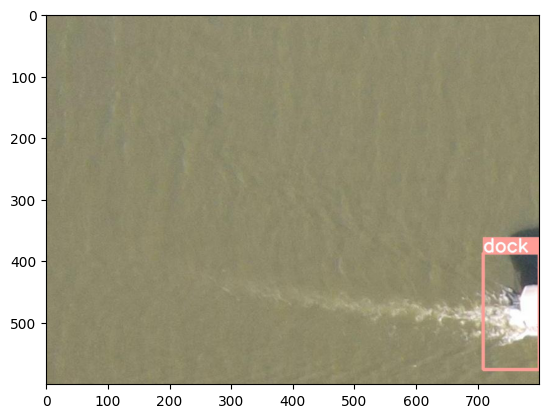

In [28]:
image = Image.open('/content/yolov5/runs/detect/exp5/100292.jpg')
plt.imshow(image)

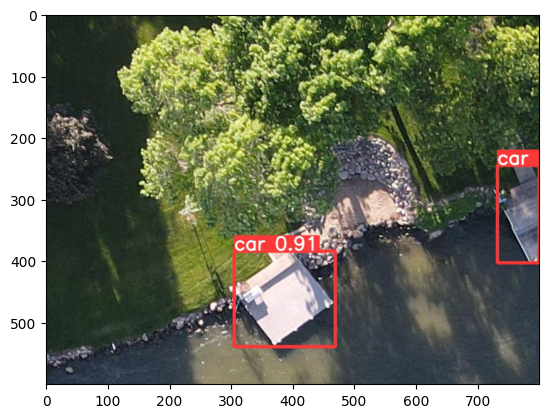

In [29]:
image = Image.open('/content/yolov5/runs/detect/exp6/101340.jpg')
plt.imshow(image)

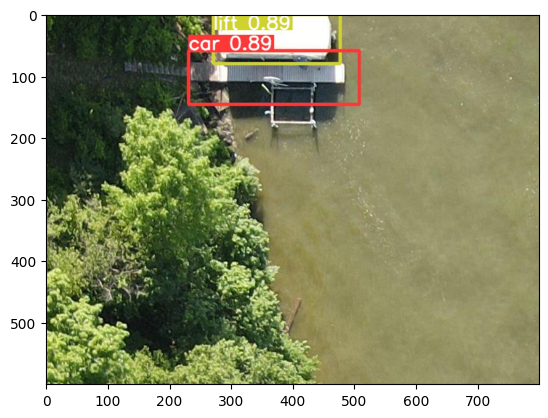

In [30]:
image = Image.open('/content/yolov5/runs/detect/exp7/100770.jpg')
plt.imshow(image)

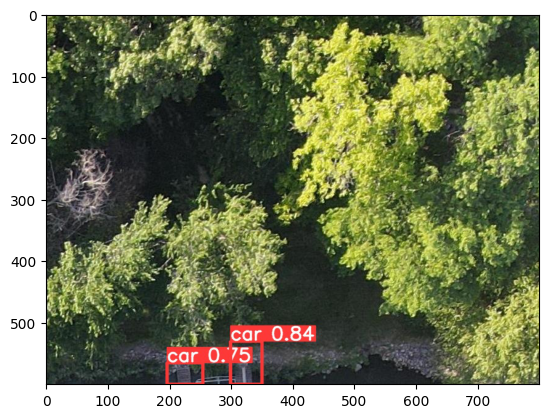

In [31]:
image = Image.open('/content/yolov5/runs/detect/exp8/101809.jpg')
plt.imshow(image)

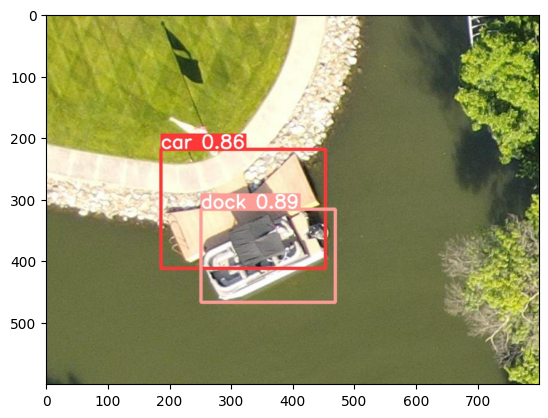

In [32]:
image = Image.open('/content/yolov5/runs/detect/exp9/101634.jpg')
plt.imshow(image)

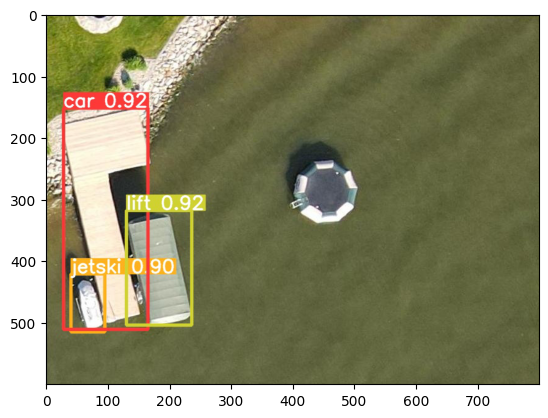

In [33]:
image = Image.open('/content/yolov5/runs/detect/exp10/101613.jpg')
plt.imshow(image)

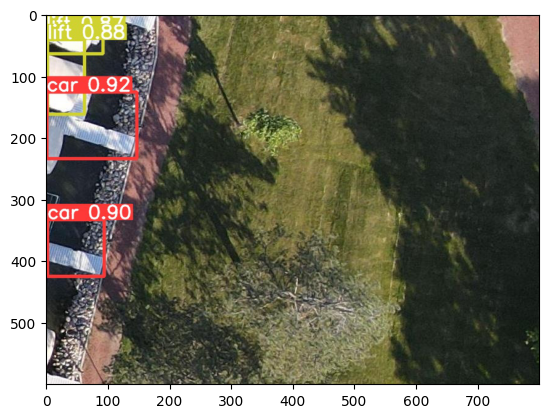

In [34]:
image = Image.open('/content/yolov5/runs/detect/exp11/101516.jpg')
plt.imshow(image)

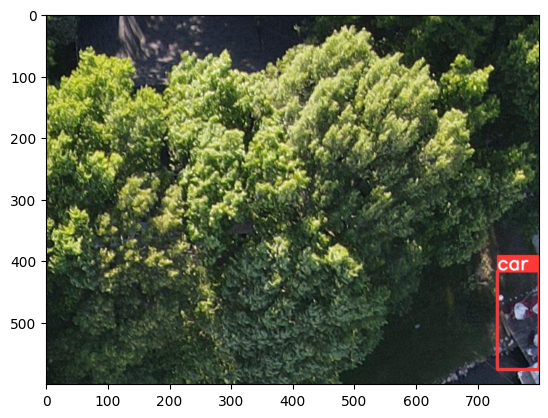

In [35]:
image = Image.open('/content/yolov5/runs/detect/exp12/101339.jpg')
plt.imshow(image)

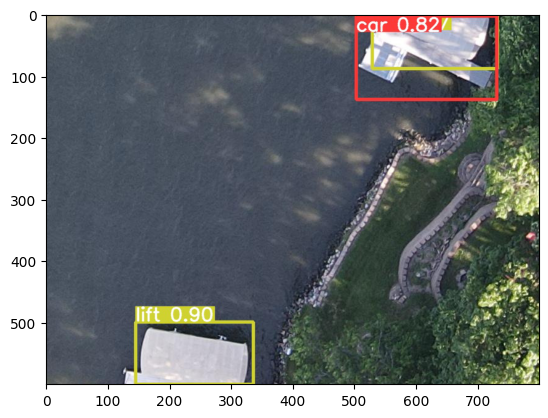

In [36]:
image = Image.open('/content/yolov5/runs/detect/exp13/101133.jpg')
plt.imshow(image)

# Step 7: Display performance analysis

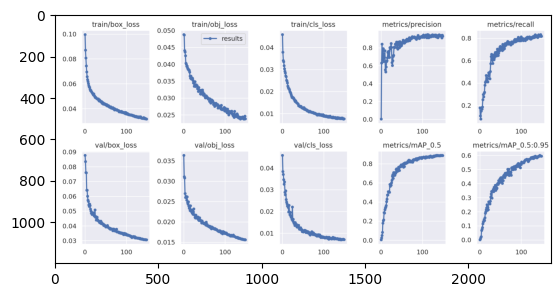

In [37]:
image = Image.open('/content/yolov5/runs/train/exp/results.png') # Change 'exp' to the last in the train directory
plt.imshow(image)

In [ ]:
pwd

'/content/yolov5'

# Step 8: Run model on validation data

In [38]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/yolov5/new_data_yaml --img 640

val: data=/content/yolov5/new_data_yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
val: Scanning /content/Object_Detection/yolo/valid/labels.cache... 307 images, 0 backgrounds, 0 corrupt: 100% 307/307 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 10/10 [00:10<00:00,  1.03s/it]
                   all        307        935      0.904      0.799      0.855      0.517
                   car        307        384      0.904      0.757      0.835      0.495
                

**mAP (IoU=0.50:0.95) on validation dataset: 0.517**

**mAP (IoU=0.50) on validation dataset: 0.855**

# Step 9: Change new_data_yaml file to run it on test data instead of validation data

In [39]:
#@title Setup Dataset Configuration (Data.yaml)
train_data_dir = "/content/Object_Detection/yolo/train" #@param {type:"string"}
val_data_dir = "/content/Object_Detection/yolo/test" #@param {type:"string"}
class_names = ['car', 'dock', 'boat', 'jetski', 'lift'] #@param {type:"raw"}
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train_data_dir}
        val: {val_data_dir}

        nc: {number_of_classes}
        names: {class_names}
        """
    )

# Step 10: Run model on test data

In [40]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/yolov5/new_data_yaml --img 640

val: data=/content/yolov5/new_data_yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
val: Scanning /content/Object_Detection/yolo/test/labels... 307 images, 0 backgrounds, 0 corrupt: 100% 307/307 [00:00<00:00, 424.84it/s]
val: New cache created: /content/Object_Detection/yolo/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 10/10 [00:10<00:00,  1.09s/it]
                   all        307        952      0.924      0.828       0.88      0.536
                   car        

**mAP (IoU=0.50:0.95) on test dataset: 0.536**

**mAP (IoU=0.50) on test dataset: 0.880**

# Step 11: Change new_data_yaml file to run it on training data

In [42]:
#@title Setup Dataset Configuration (Data.yaml)
train_data_dir = "/content/Object_Detection/yolo/train" #@param {type:"string"}
val_data_dir = "/content/Object_Detection/yolo/train" #@param {type:"string"}
class_names = ['car', 'dock', 'boat', 'jetski', 'lift'] #@param {type:"raw"}
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train_data_dir}
        val: {val_data_dir}

        nc: {number_of_classes}
        names: {class_names}
        """
    )

# Step 12: Run model on training data

In [43]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/yolov5/new_data_yaml --img 640

val: data=/content/yolov5/new_data_yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
val: Scanning /content/Object_Detection/yolo/train/labels.cache... 1435 images, 0 backgrounds, 0 corrupt: 100% 1435/1435 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 45/45 [00:32<00:00,  1.39it/s]
                   all       1435       4536      0.959      0.876      0.931      0.638
                   car       1435       1915       0.96       0.84      0.922      0.614
             

**mAP (IoU=0.50:0.95) on training dataset: 0.638**

**mAP (IoU=0.50) on training dataset: 0.931**